# 序列预测实例 - 北京空气污染预测（Sequence Prediction Example - Beijing Air Pollution Prediction）

## 导入库

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## 数据读取与观察

In [2]:
# 数据读取
data = pd.read_csv('./dataset/PRSA_data_2010.1.1-2014.12.31.csv')
# 查看前五条数据
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


**数据说明：**
| no | english |   chinese   |
|:--:|:-------:|:-----------:|
| 1  | No      | 行数        |
| 2  | year    | 年          |
| 3  | month   | 月          |
| 4  | day     | 日          |
| 5  | hour    | 小时        |
| 6  | pm2.5   | PM2.5浓度   |
| 7  | DEWP    | 露点        |
| 8  | TEMP    | 温度        |
| 9  | PRES    | 大气压      |
| 10 | cbwd    | 风向        |
| 11 | lws     | 风速        |
| 12 | lss     | 累计雪量    |
| 13 | lr      | 累计雨量    |

In [3]:
# 查看数据信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [4]:
# 查看数据缺失情况
print('缺失值数量：', data['pm2.5'].isna().sum())
data[data['pm2.5'].isna()]

缺失值数量： 2067


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43548,43549,2014,12,20,12,NaN,-18,0.0,1030.0,NW,244.97,0,0
43549,43550,2014,12,20,13,NaN,-19,1.0,1029.0,NW,249.89,0,0
43550,43551,2014,12,20,14,NaN,-20,1.0,1029.0,NW,257.04,0,0
43551,43552,2014,12,20,15,NaN,-20,2.0,1028.0,NW,262.85,0,0


In [5]:
# 直接删除前24条PM2.5的缺失值
data = data.iloc[24:].ffill()        # iloc：按位置索引选择数据, ffill：用前一个非缺失值填充缺失值
# 查看数据信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 24 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43800 non-null  int64  
 1   year    43800 non-null  int64  
 2   month   43800 non-null  int64  
 3   day     43800 non-null  int64  
 4   hour    43800 non-null  int64  
 5   pm2.5   43800 non-null  float64
 6   DEWP    43800 non-null  int64  
 7   TEMP    43800 non-null  float64
 8   PRES    43800 non-null  float64
 9   cbwd    43800 non-null  object 
 10  Iws     43800 non-null  float64
 11  Is      43800 non-null  int64  
 12  Ir      43800 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


## 数据预处理

In [6]:
# 将时间合并为一列
import datetime
data['time'] = data.apply(lambda x: datetime.datetime(year=x['year'],
                                                    month=x['month'],
                                                    day=x['day'], 
                                                    hour=x['hour']), 
                          axis=1)       # apply：对数据集的每一行或每一列应用函数，axis=1表示对每一行应用函数
data.set_index('time', inplace=True)      # set_index：将某一列设置为索引
# 删除不需要的列（两种方式）
data.drop('No', axis=1, inplace=True)       # 删除No编号列
data.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)      # drop：删除数据集中的列

In [7]:
data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
time,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [8]:
# 查看风向的唯一值
data.cbwd.unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [9]:
# 将风向独热编码后添加到数据列中
data = data.join(pd.get_dummies(data.cbwd))
# 删除不需要的列cbwd（第三种方法）
del data['cbwd']
# 查看数据信息
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm2.5   43800 non-null  float64
 1   DEWP    43800 non-null  int64  
 2   TEMP    43800 non-null  float64
 3   PRES    43800 non-null  float64
 4   Iws     43800 non-null  float64
 5   Is      43800 non-null  int64  
 6   Ir      43800 non-null  int64  
 7   NE      43800 non-null  bool   
 8   NW      43800 non-null  bool   
 9   SE      43800 non-null  bool   
 10  cv      43800 non-null  bool   
dtypes: bool(4), float64(4), int64(3)
memory usage: 2.8 MB


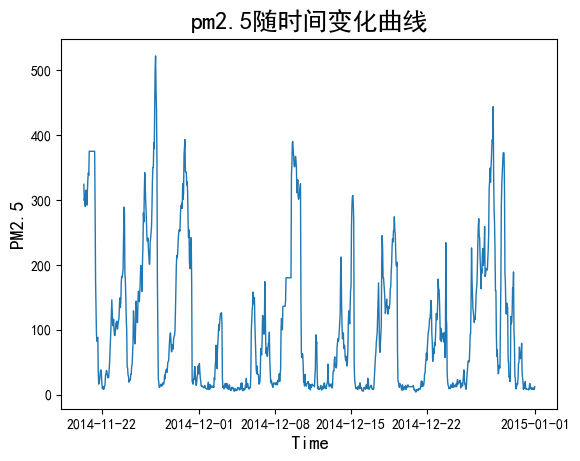

In [10]:
# 查看最后1000次观测PM2.5的变化情况
plt.plot(data['pm2.5'][-1000:],linewidth=1) #设置线条宽度
#设置图标标题，并在坐标轴上添加标签
plt.title("pm2.5随时间变化曲线",fontsize=18)
plt.xlabel('Time',fontsize=14)
plt.ylabel('PM2.5',fontsize=14)

plt.rcParams['font.sans-serif']=['SimHei'] # 用来正常显示中文标签（中文乱码问题）

plt.show() # 展示图形

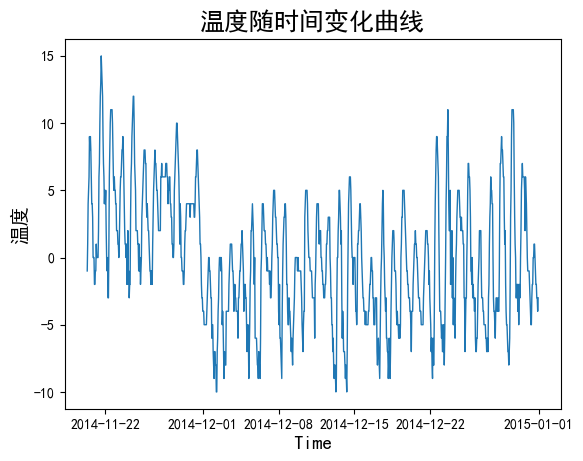

In [11]:
# 查看最后1000次观测温度的变化情况
plt.plot(data['TEMP'][-1000:],linewidth=1) #设置线条宽度
#设置图标标题，并在坐标轴上添加标签
plt.title("温度随时间变化曲线",fontsize=18)
plt.xlabel('Time',fontsize=14)
plt.ylabel('温度',fontsize=14)

plt.rcParams['font.sans-serif']=['SimHei'] # 用来正常显示中文标签（中文乱码问题）
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

plt.show() # 展示图形

In [12]:
# 使用前5天的数据预测第6天的PM2.5浓度
sequence_length = 5*24      # sequence_length：序列长度，即观测前五天的数据
delay = 24                  # delay：延迟，即预测第6天的数据

In [13]:
# 将数据集按照观测数据和预测数据进行重构
data_ = []
for i in range(len(data) - sequence_length - delay):        # 从第0个数据开始，到第len(data) - sequence_length - delay个数据结束
    data_.append(data.iloc[i: i + sequence_length + delay]) # iloc：按位置索引选择数据，从第i个数据开始，到第i + sequence_length + delay个数据结束
# 将数据集从dataframe转换为numpy数组
data_ = np.array([dataframe.values for dataframe in data_])
# 查看数据集的形状
print('数据集的形状：', data_.shape)

数据集的形状： (43656, 144, 11)


In [14]:
# 对数据集进行随机打乱
np.random.shuffle(data_)
# 提取数据集中的观测数据和预测数据
x = data_[:, : sequence_length, :]      # x：观测数据，从第0个数据开始，到第sequence_length个数据结束，取所有列的数据
y = data_[:, -1, 0]      # y：预测数据，预测一天后的数据，即间隔24小时，只取第0列的数据
x.shape, y.shape

((43656, 120, 11), (43656,))

In [15]:
# 统一数据类型
x = x.astype(np.float32)
y = y.astype(np.float32)
# 划分训练集和测试集
split_boundary = int(data_.shape[0] * 0.8)

train_x = x[: split_boundary]
test_x = x[split_boundary:]

train_y = y[: split_boundary]
test_y = y[split_boundary:]

# 查看训练集和测试集的形状
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((34924, 120, 11), (8732, 120, 11), (34924,), (8732,))

In [16]:
# 标准化数据
# 计算训练集的均值和标准差
mean = train_x.mean(axis=0)     # axis=0：按列计算均值
std = train_x.std(axis=0)
print('The mean shape is:', mean.shape)
print('The std shape is:', std.shape)
# 对训练集和测试集进行标准化
train_x = (train_x - mean)/std
test_x = (test_x - mean)/std

The mean shape is: (120, 11)
The std shape is: (120, 11)


## 创建Dataset

In [17]:
# 自定义数据集类
class PRSA_dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return len(self.features)

In [18]:
# 初始化训练集和测试集
train_ds = PRSA_dataset(train_x, train_y)
test_ds = PRSA_dataset(test_x, test_y)

In [19]:
# 创建数据加载器
BTACH_SIZE = 128
train_dl = torch.utils.data.DataLoader(
                                       train_ds,
                                       batch_size=BTACH_SIZE,
                                       shuffle=True
)
test_dl = torch.utils.data.DataLoader(
                                       test_ds,
                                       batch_size=BTACH_SIZE
)

## 模型构建

In [20]:
# 定义LSTM的hidden_size参数
hidden_size = 64

In [21]:
# 定义时序预测模型
class Net(nn.Module):
    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(input_size=train_x.shape[-1], 
                           hidden_size=hidden_size, 
                           batch_first=True)         # batch_first：输入和输出的形状为(batch_size, sequence_length, input_size)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, 1)                # 回归问题，输出为1

    def forward(self, inputs):
        _, state_output = self.rnn(inputs)          # LSTM的输出为两个值，第一个值为输出，第二个值为状态输出
        state_output = state_output[-1]             # 状态输出包含所有的隐藏状态，我们只需要最后一个隐藏状态
        x = F.dropout(F.relu(self.fc1(state_output)))
        x = self.fc2(x)                             # size: (batch_size, 1) 
        return torch.squeeze(x)                     # torch.squeeze：去掉size为1的维度 x.shape：(128, 1) ---> labels.shape：128

## 模型训练

In [22]:
# 初始化模型
model = Net(hidden_size)
model

Net(
  (rnn): LSTM(11, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [23]:
# 参数整理
model = model
learn_rate = 0.001
epochs = 100
train_dl = train_dl
test_dl = test_dl

# 训练前准备，定义模型、损失函数、优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU，如果有则使用GPU，否则使用CPU
model.to(device) # 将已实例化的模型移动到GPU上

loss_fn = torch.nn.MSELoss()  # 损失函数，均方误差
opt = torch.optim.Adam(model.parameters(), lr=learn_rate) # 优化器，Adam优化器

# 通用训练模板(回归问题等无准确率)，输入模型、训练数据、测试数据，返回loss变化
# 训练函数
def train(train_dl, model, loss_fn, opt):
    size = len(train_dl.dataset) # 获取数据集的大小

    train_loss = 0.0 # 训练集损失

    for x, y in train_dl: # 遍历数据集
        x, y = x.to(device), y.to(device) # 将数据移动到GPU上

        pred = model(x) # 前向传播
        loss = loss_fn(pred, y) # 计算损失

        opt.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        opt.step() # 更新参数

        with torch.no_grad(): # 不计算梯度
            train_loss += loss.item() # 计算损失

    train_loss /= size # 计算平均损失

    return train_loss

# 测试函数
def test(test_dl, model, loss_fn):
    size = len(test_dl.dataset) # 获取数据集的大小

    test_loss = 0.0 # 测试集损失

    with torch.no_grad(): # 不计算梯度
        for x, y in test_dl:  # 遍历数据集
            x, y = x.to(device), y.to(device) # 将数据移动到GPU上

            pred = model(x) # 前向传播
            loss = loss_fn(pred, y) # 计算损失
            test_loss += loss.item() # 计算损失

    test_loss /= size # 计算平均损失

    return test_loss
# 训练函数
def fit(epochs, model, train_dl, test_dl, loss_fn, opt):
    train_loss = []
    test_loss = []

    print_template = 'Epoch: {}, Train Loss: {:.4f}, Test Loss: {:.4f}'


    for epoch in range(epochs):
        model.train() # 设置模型为训练模式，启用dropout层
        epoch_train_loss = train(train_dl, model, loss_fn, opt)
        model.eval() # 设置模型为评估预测模式，禁用dropout层
        epoch_test_loss = test(test_dl, model, loss_fn)

        train_loss.append(epoch_train_loss)
        test_loss.append(epoch_test_loss)

        print(print_template.format(epoch, epoch_train_loss, epoch_test_loss))

    return train_loss, test_loss

# 训练
train_loss, test_loss = fit(epochs, model, train_dl, test_dl, loss_fn, opt)

Epoch: 0, Train Loss: 67.6166, Test Loss: 54.9005
Epoch: 1, Train Loss: 55.2400, Test Loss: 52.8404
Epoch: 2, Train Loss: 53.6609, Test Loss: 55.1285
Epoch: 3, Train Loss: 52.9382, Test Loss: 50.5912
Epoch: 4, Train Loss: 51.8590, Test Loss: 49.9592
Epoch: 5, Train Loss: 51.3453, Test Loss: 51.2837
Epoch: 6, Train Loss: 49.9950, Test Loss: 48.6517
Epoch: 7, Train Loss: 48.7256, Test Loss: 47.4944
Epoch: 8, Train Loss: 47.4113, Test Loss: 47.0924
Epoch: 9, Train Loss: 46.8234, Test Loss: 46.1393
Epoch: 10, Train Loss: 45.1762, Test Loss: 47.7003
Epoch: 11, Train Loss: 44.6877, Test Loss: 45.3307
Epoch: 12, Train Loss: 44.0473, Test Loss: 43.9458
Epoch: 13, Train Loss: 41.8697, Test Loss: 41.7819
Epoch: 14, Train Loss: 40.3522, Test Loss: 41.7795
Epoch: 15, Train Loss: 39.1204, Test Loss: 38.7822
Epoch: 16, Train Loss: 37.2179, Test Loss: 38.4668
Epoch: 17, Train Loss: 36.2513, Test Loss: 36.0648
Epoch: 18, Train Loss: 43.7245, Test Loss: 41.1774
Epoch: 19, Train Loss: 38.7589, Test Loss

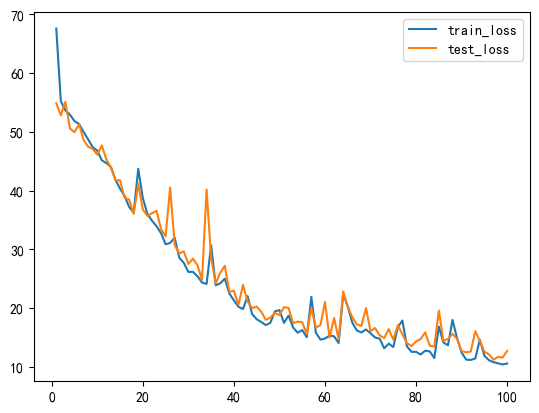

In [24]:
# 可视化损失值变化
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

## 批量预测（一）

In [25]:
# 保存模型
model_path = './model/custom_sequence_prediction_model_for_air_pollution.pth'
torch.save(model.state_dict(), model_path) # 保存模型参数

In [26]:
# 查看待预测数据
print('The shape of test_x:', test_x.shape)        # (n, sequence_length, input_size)(n, 120, 11)
print('the type of test_x:', type(test_x))       # <class 'torch.Tensor'>

The shape of test_x: (8732, 120, 11)
the type of test_x: <class 'numpy.ndarray'>


In [27]:
# 预测，将ndarray数据转换为tensor
pred_test_x = model(torch.from_numpy(test_x).to(device))

In [28]:
# 查看预测结果
print('The shape of pred_test_x:', pred_test_x.shape)  # (n, 1)
pred_test_x[:4]

The shape of pred_test_x: torch.Size([8732])


tensor([ 10.1695,  11.2945, 109.5086,  44.5505], device='cuda:0',
       grad_fn=<SliceBackward0>)